In [122]:
import numpy as np

import matplotlib.pyplot as plt

Continuing with orbits around the Sun we first will define the ODE system

In [123]:
G = 4*np.pi**2

M_sun = 1.0

In [124]:
def rhs(t, Y):
  x, y, vx, vy = Y

  xdot = vx
  ydot = vy
  r = np.sqrt(x*x + y*y)

  vxdot = -G * M_sun * x / r**3
  vydot = -G * M_sun * y / r**3

  return np.array([xdot, ydot, vxdot, vydot])

Orbit History class to store solutions while integrating

A function to calculate the error so that we can look at the convergence of the numerical schemes

Make a plot function of the solution

In [131]:
class OrbitHistory:
  
  """store the time history of the orbit solution"""
  def __init__(self):
    self.t = []
    self.x = []
    self.y = []
    self.vx = []
    self.vy = []

  def store_current_solution(self, t, Y):
    self.t.append(t)
    self.x.append(Y[0])
    self.y.append(Y[1])
    self.vx.append(Y[2])
    self.vy.append(Y[3])

  def error_radius(self):
    """return the difference in the distance to the Sun"""
    R_orig = np.sqrt(self.x[0]**2 + self.y[0]**2)
    R_new = np.sqrt(self.x[-1]**2 + self.y[-1]**2)

    return np.abs(R_new - R_orig)


  def error_position(self):
    """return the difference in the distance from the Sun"""
    dx = self.x[0] - self.x[-1]
    dy = self.y[0] - self.y[-1]

    return np.sqrt(dx**2 + dy**2)


  def plot(self, ax=None, label=None):
    """make a plot of the solution. If ax is None we setup a figure and make the entire plot returning the figure object, otherwise, just append the plot to the current axis"""

    fig = None

    if ax is None:
      fig = plt.figure(figsize=(15,15))
      ax = fig.add_subplot(111)

      # draw the Sun
      ax.scatter([0], [0], marker=(20,1), color="y", s=250)

    # draw the orbit
    ax.plot(self.x, self.y, label=label)

    if fig is not None:
      ax.set_aspect("equal")
      ax.set_xlabel("x, [AU]")
      ax.set_ylabel("y, [AU]")

      return fig, ax

# 2nd-Order Runge-Kutta

For $ \frac{dy}{dx} = f(x,y)$, $y(0) = y_{0}$

Runge-Jutta 2nd-Order method is given by:

$$ y_{i+1} = y_{i} + (a_{1} k_{1} + a_{2} k_{2}) h$$

where $k_{1} = f(x_{i}, y_{i})$ and $k_{2} = f(x_{i} + p_{1}h, y_{i} + q_{11} k_{1} h)$


Each mehtod can be summarised as a list of the parameters $ \textrm{P} = \left( \begin{array} \\ a_{1} \\ a_{2} \\ p_{1} \\ q_{11} \end{array} \right)$ 


Huen's Method: $ \textrm{P} = \left( \begin{array} \\ \frac{1}{2} \\ \frac{1}{2} \\ 1 \\ 1 \end{array} \right)$ 

Midpoint Method: $ \textrm{P} = \left( \begin{array} \\ 0 \\ 1 \\ \frac{1}{2} \\ \frac{1}{2} \end{array} \right)$ 

Ralston's Mathod: $ \textrm{P} = \left( \begin{array} \\ \frac{1}{3} \\ \frac{2}{3} \\ \frac{3}{4} \\ \frac{3}{4} \end{array} \right)$ 

Let's build the RK2 Midpoint Method

In [132]:
def euler_rk2(Y0, tau, T):

  # return an orbit history object
  o = OrbitHistory()

  # storage of new solution
  Y = Y0.copy()

  # initialize time
  t = 0

  # store the initial conditions
  o.store_current_solution(t, Y0)

  # main timestep loop
  while t < T:

      # make sure the last time step does not take the solution past T
      if t + tau > T:
        tau = T - t

      # get the RHS of the ODE
      Ydot = rhs(t, Y)

      # predict the state at the midpoint
      Ytmp = Y + 0.5 * tau * Ydot

      # evaluate the RHS at the midpoint
      Ydot = rhs(t + 0.5*tau, Ytmp)

      # do the final update
      Y += tau * Ydot
      t += tau

      # store the current state of the solution
      o.store_current_solution(t, Y)

  return o 

Setup the initial conditions

In [133]:
def initial_conditions():
  x0 = 0
  y0 = 1
  vx0 = -np.sqrt(G * M_sun / y0)
  vy0 = 0

  return np.array([x0, y0, vx0, vy0])

Integrate the orbit

In [134]:
T = 1
tau = T/12.0

Y0 = initial_conditions()

In [135]:
orbit = euler_rk2(Y0, tau, 1)

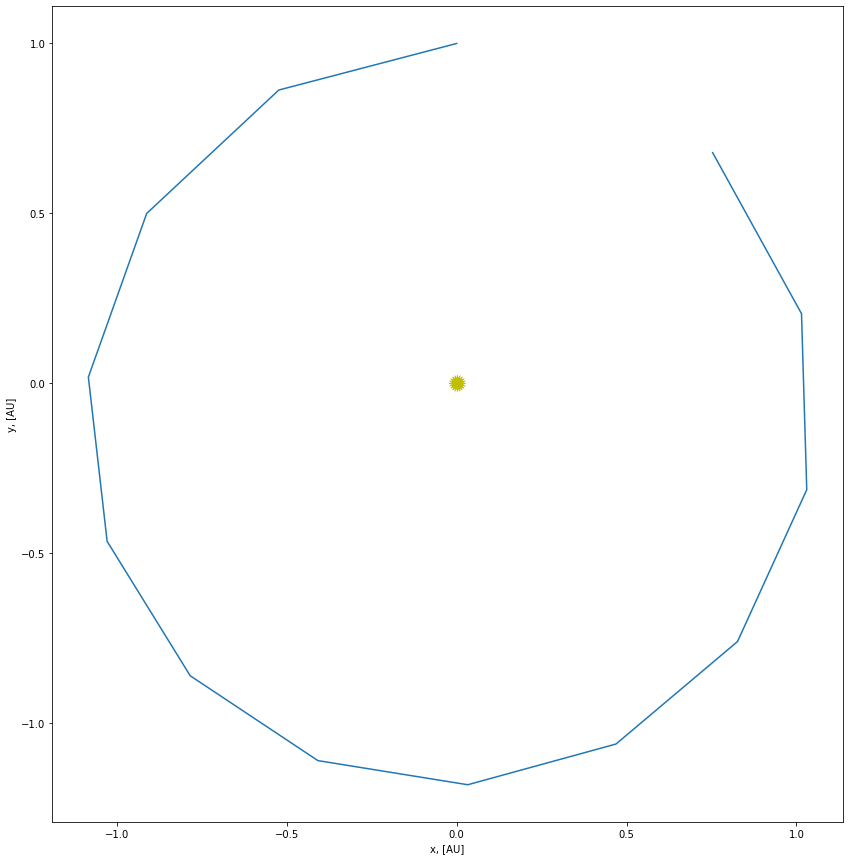

In [136]:
fig = orbit.plot()

Let's now do this over a range of timesteps

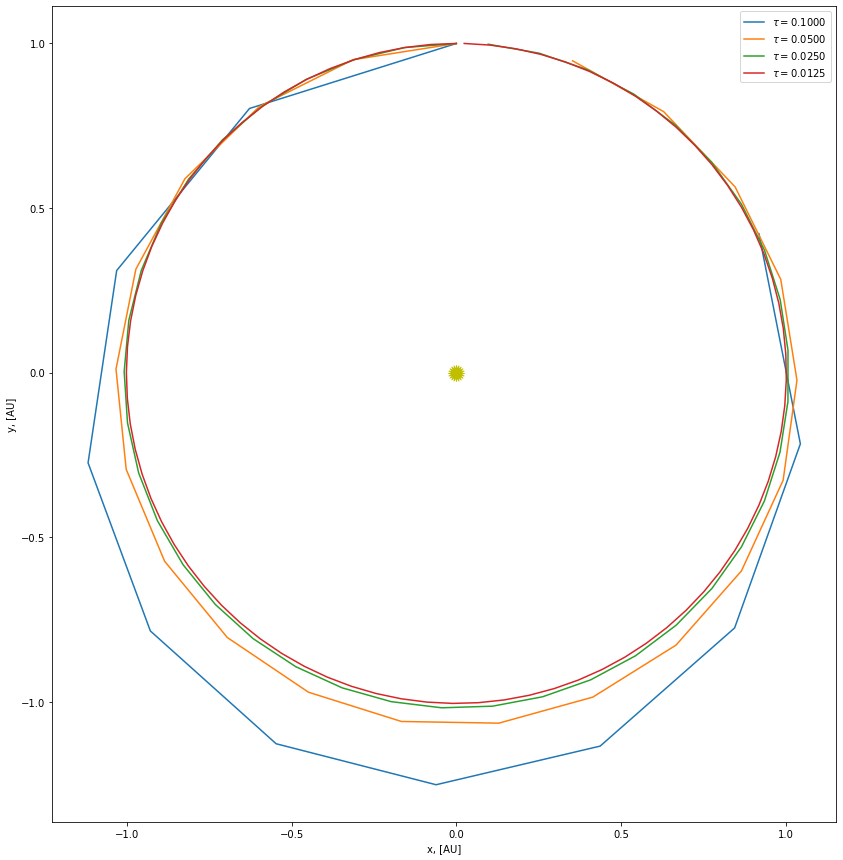

In [137]:
taus = [0.1, 0.05, 0.025, 0.0125]

for n, tau in enumerate(taus):
  orbit = euler_rk2(Y0, tau, 1)

  if n == 0:
    fig, ax = orbit.plot(label=rf"$\tau = {tau:6.4f}$")

  else:
    orbit.plot(ax=ax, label=rf"$\tau = {tau:6.4f}$")

ax.legend()

Does the error converge?

In [138]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
  o = euler_rk2(Y0, tau, 1)

  print(f"tau = {tau:8.5f}, error = {o.error_radius():10.5g} {o.error_position():10.5g}")

tau =  0.10000, error =     0.0116     1.0856
tau =  0.05000, error =   0.011123    0.35694
tau =  0.02500, error =  0.0024709   0.096669
tau =  0.01250, error = 0.00036069   0.023906
tau =  0.00625, error = 4.6926e-05  0.0058463


# 4th - Order Runge-Kutta

Consider the ODE $\dot{y} = f(y) $

The first estimate is the derivatibe: $ k_{1} = f(t^{n}, y^{n})$

Then we follow the slope of $K_{1}$ to the midpoint in time $t^{n+1/2}$ and evaluate the slope there which is : $k_{2} = f(t^{n} + \frac{\tau}{2}, y^{n} + (\frac{\tau}{2}) k_{1})$

We go back to the start and follow the new slope $k_{2}$ to the time midpoint $t^{n + 1/2}$ and evaluate the slope as: $k_{3} = f(t^{n} + \frac{\tau}{2}, y^{n} + (\frac{\tau}{2}) k_{2})$

Finally, we go back and start again and follow $k_{3}$ for the full timestep $t^{n+1}$ and evaluate the slope as: $k_{4} = f(t^{n} + \tau, y^{n} + \tau k_{3})$


The final solution update is a linear combination of the four different slopes:

$$y^{n+1} = y^{n} + \frac{\tau}{6} (k_{1} +2 k_{2} + 2 k_{3} + k_{4})$$


This method is very similar to Simpson's Rule for integration

In [177]:
def euler_rk4(Y0, tau, T):

  # return an orbit history object
  o = OrbitHistory()

  # storage of the new solution
  Y = Y0.copy()

  # initialize time
  t = 0

  # store the initial conditions
  o.store_current_solution(t, Y0)

  # main timestep loop
  while t < T:
      # make sure the last timestep does not take the solution past T
      if t + tau > T:
        tau = T - t

      # get the RHS of the ODE
      k1 = rhs(t, Y)

      Ytmp = Y + 0.5 * tau * k1
      k2 = rhs(t + 0.5 * tau, Ytmp)

      Ytmp = Y + 0.5 * tau * k2
      k3 = rhs(t + 0.5 * tau, Ytmp)

      Ytmp = Y + tau * k3
      k4 = rhs(t + tau, Ytmp)

      # do the final update
      Y += tau / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
      t += tau

      # store the current state of the solution
      o.store_current_solution(t, Y)

  return o

In [178]:
Y0 = initial_conditions()

T = 1.0
tau = T/12.0

In [179]:
orbit = euler_rk4(Y0, tau, T)

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56de83e390>)

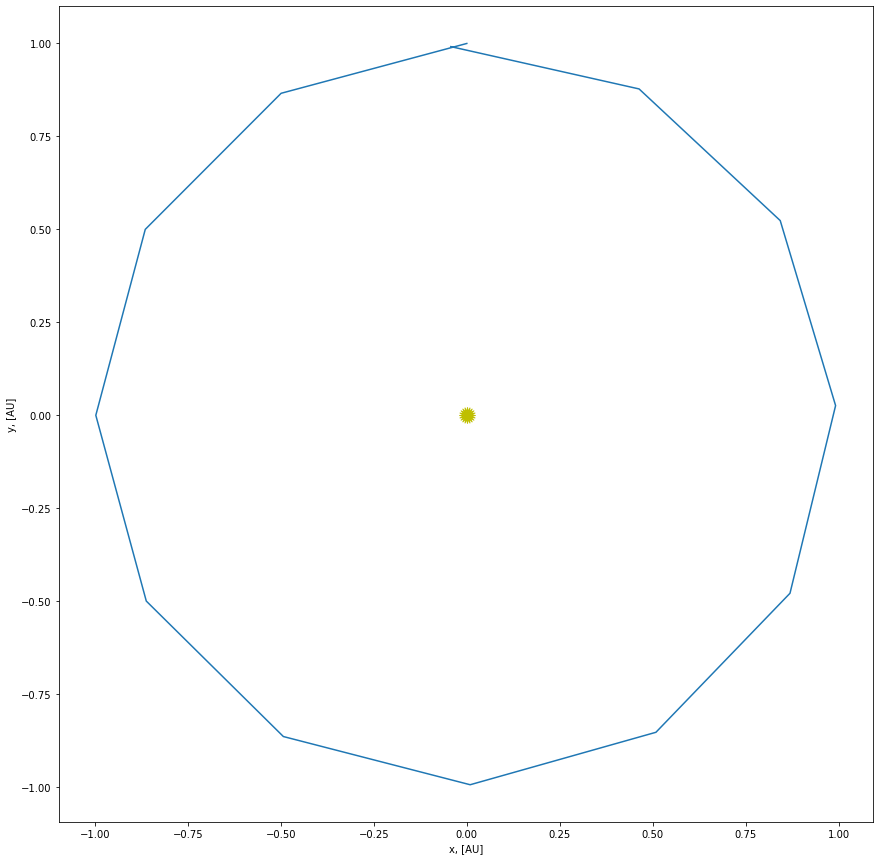

In [180]:
orbit.plot()

Looking at the convergence of RK4 over a range of timesteps

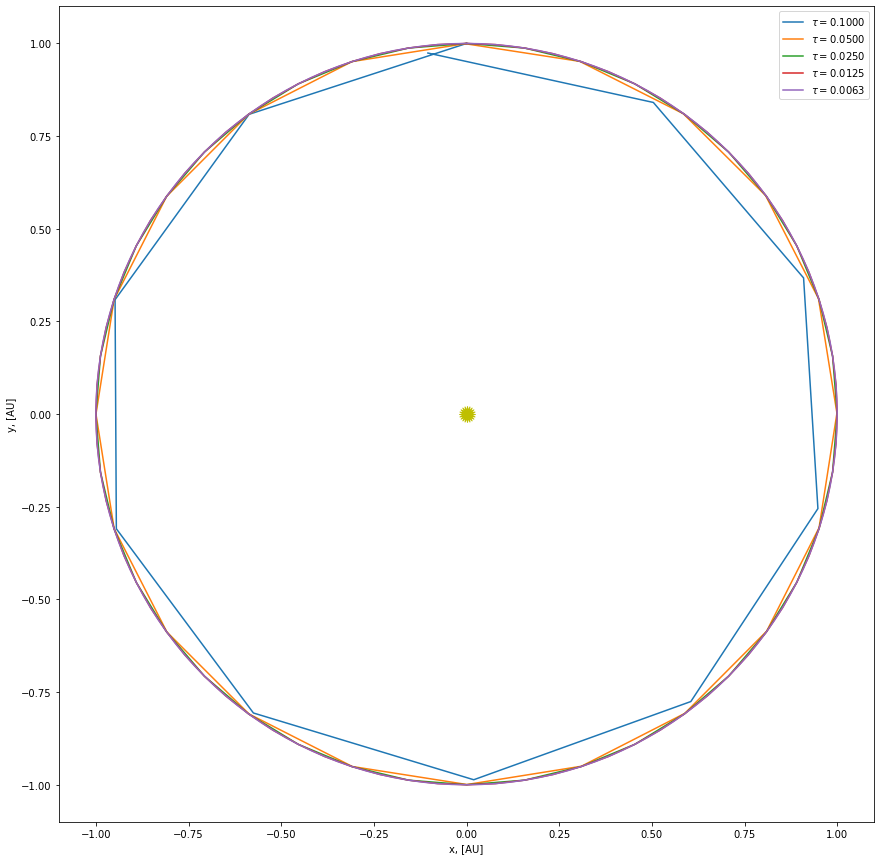

In [183]:
taus = [0.1, 0.05, 0.025, 0.0125, 0.00625]

for n, tau in enumerate(taus):
  orbit = euler_rk4(Y0, tau, 1)

  if n == 0:
    fig, ax = orbit.plot(label=rf"$\tau = {tau:6.4f}$")

  else:
    orbit.plot(ax=ax, label=rf"$\tau = {tau:6.4f}$")

ax.legend()

In [184]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
  o = euler_rk4(Y0, tau, T)
  print(f"tau = {tau:8.5f}, Radius Error = {o.error_radius():10.5g}, Position Error = {o.error_position():10.5g}")

tau =  0.10000, Radius Error =   0.020244, Position Error =     0.1074
tau =  0.05000, Radius Error = 0.00054733, Position Error =  0.0039053
tau =  0.02500, Radius Error = 1.6779e-05, Position Error = 0.00016588
tau =  0.01250, Radius Error = 5.2225e-07, Position Error = 7.9308e-06
tau =  0.00625, Radius Error = 1.6305e-08, Position Error = 4.1917e-07


We can see from the error that the 4th-order scheme is converging faster than the 2nd-order scheme

# Timestepping

In each of the above numerical schemes, the time step $\tau$ is fixed but in general, finding a solution to an ODE may necessitate changing the timestep, for instance if the solution is changing rapidly we would require a smaller timestep or a slowly changing solution could use a larger timestep.

Most ODE libraries use a form of local error estimation to measure how large the error is in the solution and adjust the timestep to achieve a desired accuracy.

Consider an elliptic orbit. A planet velocity would change rapidly at the perhelion of the orbit.

The initial conditions for a planet at the perhelion (on the $+y$ axis) are:

In [188]:
# length of semi-major axis which is the "radius" distance on the ellipse 
a = 1.0
# eccentricity which must be 0 < e < 1, which is a perfect circle if e=0 and a parabola when e=1
e = 0.6

# final time
T = 1

# initial conditions
x0 = 0
y0 = a * (1 - e)
vx0 = -np.sqrt(G * M_sun / a * (1 + e) / (1 - e))
vy0 = 0

Y0 = np.array([x0, y0, vx0, vy0])

# timestep
tau = 0.025

In [189]:
orbit = euler_rk4(Y0, tau, T)

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f55eefdcad0>)

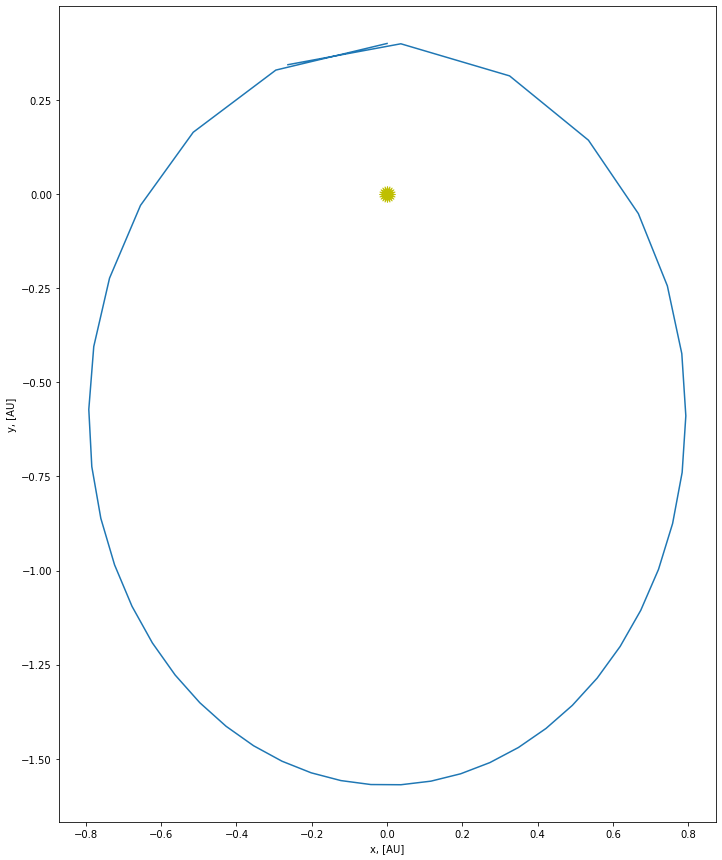

In [190]:
orbit.plot()

Now we compute the energy per unit mass

$ E = \frac{1}{2} |v|^{2} - \frac{G M_{*}}{r} $

In [191]:
x = np.array(orbit.x)
y = np.array(orbit.y)
vx = np.array(orbit.vx)
vy = np.array(orbit.vy)
t = np.array(orbit.t)

In [192]:
E = 0.5 * (vx**2 + vy**2) - G*M_sun/np.sqrt(x**2 + y**2)

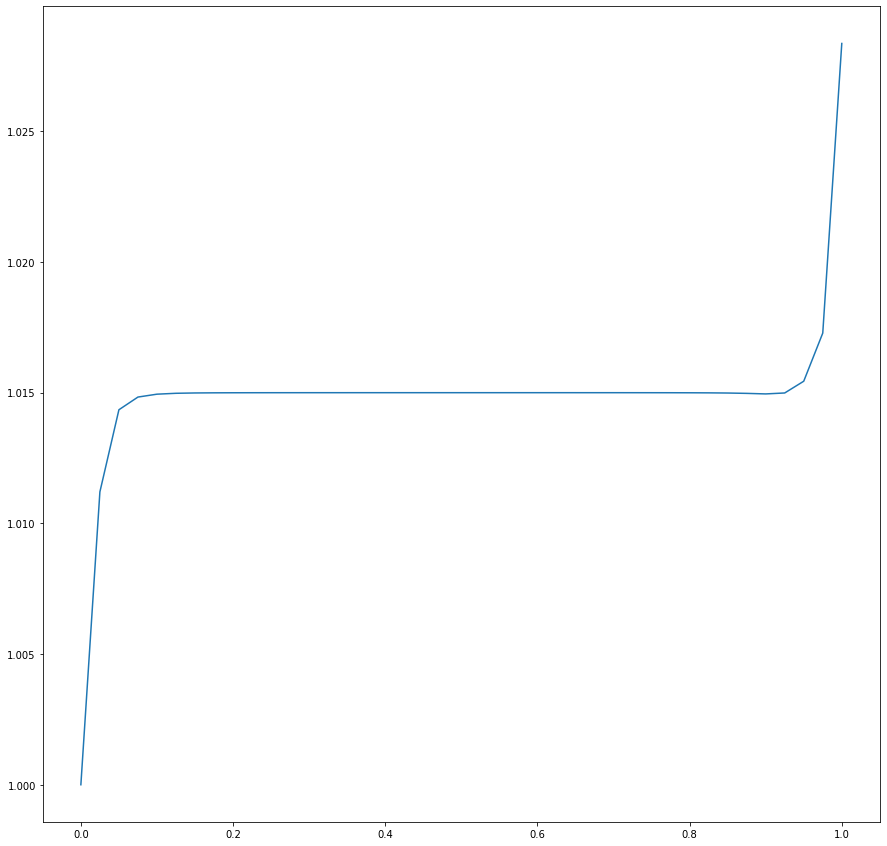

In [194]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

ax.plot(t, E/E[0])

The conservation of energy is not good and the conservation is the worst at the perhellion when the solution is changing the fastest